In [1]:
import sys
import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from datetime import datetime

import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import louvain
import torch

from scvi.dataset import Dataset10X, CsvDataset, AnnDatasetFromAnnData, CellMeasurement, LoomDataset, DownloadableAnnDataset
from scvi.dataset.dataset import GeneExpressionDataset
from scvi.inference import TotalPosterior, TotalTrainer, load_posterior
from scvi.models import SCANVI, TOTALVI
from scvi import set_seed

from umap import UMAP

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

set_seed(123)

use_cuda = True
show_plot = True
test_mode = False
HCAfolder = "/home/liesbetm/Documents/Projects/u_mgu/Charlie/singleCell_HumanCellAtlas/bigMouse_mergeNucSeq/"
sampleFolder = "//home/liesbetm/Documents/Projects/u_mgu/Jean-Francois/epigeneticsPipeline/DEgenes_full/"
sampleNameGeneral = "bigMouseRerun"

In [2]:
import os
os.getcwd()

'/srv/data/Projects/u_mgu/Charlie/singleCell_HumanCellAtlas/scripts_TotalVI'

# Reload merged dataset

In [3]:
### Load data again
import pickle
all_dataset = pickle.load(open(HCAfolder+"results_TotalVI_rerun/all_dataset_"+sampleNameGeneral+".pkl", "rb"))

In [4]:
all_dataset

GeneExpressionDataset object with n_cells x nb_genes = 185894 x 4000
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'local_vars', 'barcodes', 'batch_indices', 'local_means', 'labels', 'protein_expression'
    cell_categorical_attribute_names: 'batch_indices', 'labels'
    cell_measurements_col_mappings: {'protein_expression': 'protein_names'}

In [5]:
all_dataset.barcodes

array(['AAACCTGAGTTCGCGC-1', 'AAACCTGGTGAGGCTA-1', 'AAACCTGTCGGTGTCG-1',
       ..., 'TTGACTTTCCAATGGT-46', 'TTGTAGGTCACTCCTG-46',
       'TTTCCTCTCAGCATGT-46'], dtype='<U64')

In [6]:
all_dataset.protein_expression.shape

(185894, 190)

In [7]:
all_dataset.gene_names[0:19]

array(['Sox17', 'Sntg1', 'Adhfe1', 'Ppp1r42', 'Prex2', 'Sulf1', 'Slco5a1',
       'Lactb2', 'Stau2', 'Pkhd1', 'Gsta3', 'Khdc1a', 'Kcnq5', 'Ogfrl1',
       'Bend6', 'Dst', 'Arhgef4', 'Plekhb2', 'Neurl3'], dtype='<U64')

In [8]:
all_dataset.protein_names[0:19]

array(['adt-4-1BB', 'adt-CD102', 'adt-CD103', 'adt-CD105', 'adt-CD106',
       'adt-CD107a', 'adt-CD115', 'adt-CD117', 'adt-CD11a',
       'adt-CD11b-mh', 'adt-CD11c', 'adt-CD122', 'adt-CD124', 'adt-CD127',
       'adt-CD134', 'adt-CD135', 'adt-CD137', 'adt-CD138', 'adt-CD14'],
      dtype='<U22')

In [9]:
all_dataset.batch_indices

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [45],
       [45],
       [45]], dtype=uint16)

In [10]:
batch_mask = all_dataset.get_batch_mask_cell_measurement("protein_expression")
# Batch mask for CS93
batch_mask[9]

array([False,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True, False,  True,  True,  True, False,
       False,  True,  True, False,  True,  True,  True,  True,  True,
        True, False,  True, False,  True,  True,  True, False,  True,
       False, False,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True, False, False,
       False,  True,  True, False,  True,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False, False, False,
        True,  True,

In [11]:
print(sum(batch_mask[1])) #CS48

print(sum(batch_mask[0])) #CISE12
print(sum(batch_mask[9])) #CS93
print(sum(batch_mask[11])) #CS95
print(sum(batch_mask[16])) #CS114
print(sum(batch_mask[17])) #CS115
print(sum(batch_mask[18])) #CS136
print(sum(batch_mask[19])) #CS137
print(sum(batch_mask[20])) #CS138
print(sum(batch_mask[21])) #CS139
print(sum(batch_mask[22])) #CS140
print(sum(batch_mask[23])) #CS141
print(sum(batch_mask[24])) #CS142

print(sum(batch_mask[38])) #CISE13
print(sum(batch_mask[39])) #ARE1
print(sum(batch_mask[40])) #ARE6
print(sum(batch_mask[41])) #ARE7
print(sum(batch_mask[42])) #ARE8
print(sum(batch_mask[43])) #CS62

print(sum(batch_mask[25])) #CS144
print(sum(batch_mask[26])) #ABU1
print(sum(batch_mask[33])) #ABU17
print(sum(batch_mask[37])) #ABU21
print(sum(batch_mask[44])) #CS14
print(sum(batch_mask[45])) #CS16

0
132
141
145
136
143
177
177
181
178
175
181
180
129
190
125
129
127
133
0
0
0
0
0
0


In [12]:
### Load full dataset again
import pickle
all_dataset_full = pickle.load(open(HCAfolder+"results_TotalVI_rerun/all_dataset_"+sampleNameGeneral+"_full.pkl", "rb"))

In [13]:
all_dataset_full

GeneExpressionDataset object with n_cells x nb_genes = 185894 x 24768
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'local_vars', 'barcodes', 'batch_indices', 'local_means', 'labels', 'protein_expression'
    cell_categorical_attribute_names: 'batch_indices', 'labels'
    cell_measurements_col_mappings: {'protein_expression': 'protein_names'}

# Reload model

In [14]:
### Load data again
import pickle
full_posterior = pickle.load(open(HCAfolder+"results_TotalVI_rerun/fullPosterior_"+sampleNameGeneral+".pkl", "rb"))

In [15]:
latent, batch_indices, label, library_gene = full_posterior.sequential().get_latent()

#  Reload post_adata

In [16]:
### Load data again
import pickle
post_adata = pickle.load(open(HCAfolder+"results_TotalVI_rerun/post_adata_"+sampleNameGeneral+".pkl", "rb"))

In [17]:
post_adata.obs['sample'] = post_adata.obs['sample'].astype('category')
post_adata.obs['louvain'] = post_adata.obs['louvain'].astype('category')
post_adata.obs['type'] = post_adata.obs['type'].astype('category')

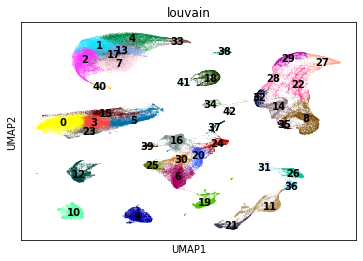

In [18]:
### Create umap
tmp=sc.pl.umap(
    post_adata, 
    color="louvain",
    ncols=1,
    alpha=0.9,
    legend_loc="on data",
#     legend_loc="right margin",
    return_fig=True
)

# Annotate

In [19]:
fileName=sampleFolder+"annotID_bigMouse_new.txt"
annotIDs = pd.read_csv(fileName, sep='\t')

In [20]:
annotIDs

,cell,annotNew,annotIDnew
0,AAACCTGAGTTCGCGC-1,T cells,1
1,AAACCTGGTGAGGCTA-1,T cells,1
2,AAACCTGTCGGTGTCG-1,ILC1s,2
3,AAACGGGAGTACGCGA-1,T cells,1
4,AAACGGGCAGTATGCT-1,ILC1s,2
...,...,...,...
185889,TTCTTAGCACATAACC-46,Neutrophils,11
185890,TTGAACGAGTGAAGTT-46,Neutrophils,11
185891,TTGACTTTCCAATGGT-46,Neutrophils,11
185892,TTGTAGGTCACTCCTG-46,Neutrophils,11


In [21]:
post_adata.obs['cell']=all_dataset.barcodes

In [22]:
post_adata.obs.index=post_adata.obs['cell']
annotIDs.index=annotIDs['cell']

In [23]:
##### Add to metaData to obs #####
tmp=pd.merge(post_adata.obs, annotIDs, left_index=True, right_index=True)
post_adata.obs=tmp

In [24]:
post_adata.obs

,louvain,sample,type,adt-4-1BB_fore_prob,adt-4-1BB_observed,adt-CD102_fore_prob,adt-CD102_observed,adt-CD103_fore_prob,adt-CD103_observed,adt-CD105_fore_prob,...,adt-TCRb5,adt-DR3,adt-TCRb8,adt-ReceptorD4,adt-IgM,adt-TIGIT,cell_x,cell_y,annotNew,annotIDnew
cell,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGTTCGCGC-1,21,1,RnaSeq,0.905823,0.0,0.439116,4.0,1.606214e-02,4.0,0.000194,...,0.364807,0.511596,0.586541,0.195244,0.285854,0.491201,AAACCTGAGTTCGCGC-1,AAACCTGAGTTCGCGC-1,T cells,1
AAACCTGGTGAGGCTA-1,11,1,RnaSeq,0.935971,0.0,0.737182,13.0,4.933953e-03,8.0,0.000154,...,0.420086,0.461517,0.798514,0.217061,0.362355,0.386907,AAACCTGGTGAGGCTA-1,AAACCTGGTGAGGCTA-1,T cells,1
AAACCTGTCGGTGTCG-1,26,1,RnaSeq,0.935434,0.0,0.091084,5.0,6.033778e-04,8.0,0.000104,...,0.273647,0.399347,0.608051,0.198158,0.324988,0.535674,AAACCTGTCGGTGTCG-1,AAACCTGTCGGTGTCG-1,ILC1s,2
AAACGGGAGTACGCGA-1,11,1,RnaSeq,0.909967,0.0,0.476049,5.0,4.858971e-03,4.0,0.000134,...,0.460532,0.429513,0.674395,0.161074,0.329464,0.447301,AAACGGGAGTACGCGA-1,AAACGGGAGTACGCGA-1,T cells,1
AAACGGGCAGTATGCT-1,26,1,RnaSeq,0.898985,0.0,0.131364,4.0,1.879930e-04,4.0,0.000074,...,0.410441,0.293530,0.726035,0.205678,0.351811,0.639528,AAACGGGCAGTATGCT-1,AAACGGGCAGTATGCT-1,ILC1s,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCTTAGCACATAACC-46,19,46,RnaSeq,0.017950,0.0,0.145087,0.0,0.000000e+00,0.0,0.000031,...,0.338603,0.370485,0.578606,0.262549,0.355164,0.454161,TTCTTAGCACATAACC-46,TTCTTAGCACATAACC-46,Neutrophils,11
TTGAACGAGTGAAGTT-46,19,46,RnaSeq,0.066216,0.0,0.036839,0.0,0.000000e+00,0.0,0.000005,...,0.360891,0.408254,0.602533,0.180624,0.165370,0.597374,TTGAACGAGTGAAGTT-46,TTGAACGAGTGAAGTT-46,Neutrophils,11
TTGACTTTCCAATGGT-46,19,46,RnaSeq,0.124326,0.0,0.372255,0.0,1.192093e-07,0.0,0.000010,...,0.332594,0.386852,0.627954,0.220217,0.311667,0.514058,TTGACTTTCCAATGGT-46,TTGACTTTCCAATGGT-46,Neutrophils,11


In [25]:
post_adata.obs['annotNew'] = post_adata.obs['annotNew'].astype('category')
post_adata.obs['annotIDnew'] = post_adata.obs['annotIDnew'].astype('category')

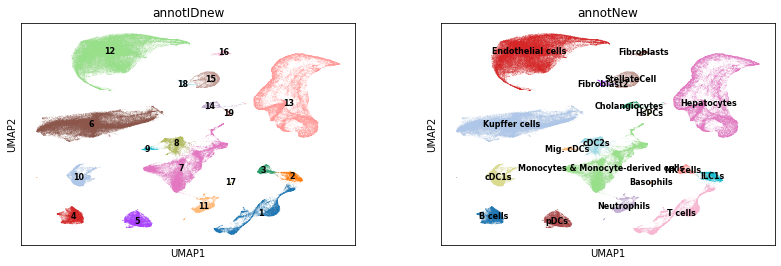

In [27]:
### Create umap
umapAnnotID=sc.pl.umap(
    post_adata, 
    color=["annotIDnew","annotNew"],
    alpha=0.9,
    legend_loc="on data",
    legend_fontsize=8,
#     legend_loc="right margin",
    return_fig=True
)

# Get DE genes via Scanpy

### Create adata of full dataset

In [28]:
post_adata_full = sc.AnnData(X=all_dataset_full.X)
post_adata_full.var.index = all_dataset_full.gene_names

In [29]:
sc.pp.normalize_total(post_adata_full, target_sum=1e4, exclude_highly_expressed=True)

In [30]:
sc.pp.log1p(post_adata_full)

In [31]:
post_adata_full.obsm["X_totalVI"] = post_adata.obsm["X_totalVI"]
post_adata_full.obsm['X_umap']=post_adata.obsm['X_umap']

In [32]:
post_adata_full.obs['cell']=all_dataset_full.barcodes
post_adata_full.obs.index=post_adata_full.obs['cell']

In [33]:
post_adata_full.obs

,cell
cell,
AAACCTGAGTTCGCGC-1,AAACCTGAGTTCGCGC-1
AAACCTGGTGAGGCTA-1,AAACCTGGTGAGGCTA-1
AAACCTGTCGGTGTCG-1,AAACCTGTCGGTGTCG-1
AAACGGGAGTACGCGA-1,AAACGGGAGTACGCGA-1
AAACGGGCAGTATGCT-1,AAACGGGCAGTATGCT-1
...,...
TTCTTAGCACATAACC-46,TTCTTAGCACATAACC-46
TTGAACGAGTGAAGTT-46,TTGAACGAGTGAAGTT-46
TTGACTTTCCAATGGT-46,TTGACTTTCCAATGGT-46


In [34]:
post_adata.obs[['louvain','sample','annotNew','annotIDnew']]

,louvain,sample,annotNew,annotIDnew
cell,,,,
AAACCTGAGTTCGCGC-1,21,1,T cells,1
AAACCTGGTGAGGCTA-1,11,1,T cells,1
AAACCTGTCGGTGTCG-1,26,1,ILC1s,2
AAACGGGAGTACGCGA-1,11,1,T cells,1
AAACGGGCAGTATGCT-1,26,1,ILC1s,2
...,...,...,...,...
TTCTTAGCACATAACC-46,19,46,Neutrophils,11
TTGAACGAGTGAAGTT-46,19,46,Neutrophils,11
TTGACTTTCCAATGGT-46,19,46,Neutrophils,11


In [35]:
##### Add to metaData to obs #####
tmp=pd.merge(post_adata_full.obs, post_adata.obs[['louvain','sample','annotNew','annotIDnew']], left_index=True, right_index=True)
post_adata_full.obs=tmp

In [36]:
post_adata_full.obs

,cell,louvain,sample,annotNew,annotIDnew
cell,,,,,
AAACCTGAGTTCGCGC-1,AAACCTGAGTTCGCGC-1,21,1,T cells,1
AAACCTGGTGAGGCTA-1,AAACCTGGTGAGGCTA-1,11,1,T cells,1
AAACCTGTCGGTGTCG-1,AAACCTGTCGGTGTCG-1,26,1,ILC1s,2
AAACGGGAGTACGCGA-1,AAACGGGAGTACGCGA-1,11,1,T cells,1
AAACGGGCAGTATGCT-1,AAACGGGCAGTATGCT-1,26,1,ILC1s,2
...,...,...,...,...,...
TTCTTAGCACATAACC-46,TTCTTAGCACATAACC-46,19,46,Neutrophils,11
TTGAACGAGTGAAGTT-46,TTGAACGAGTGAAGTT-46,19,46,Neutrophils,11
TTGACTTTCCAATGGT-46,TTGACTTTCCAATGGT-46,19,46,Neutrophils,11


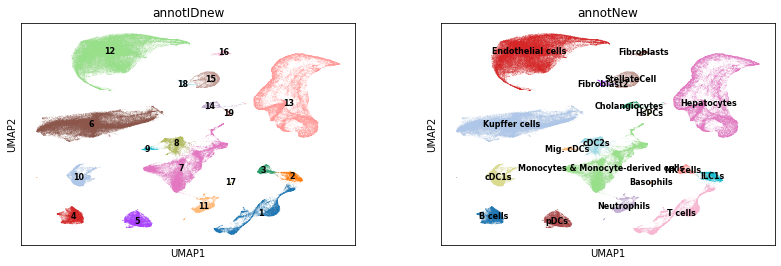

In [37]:
### Create umap
fig=sc.pl.umap(
    post_adata_full, 
    color=["annotIDnew","annotNew"],
    alpha=0.9,
    legend_loc="on data",
    legend_fontsize=8,
#     legend_loc="right margin",
    return_fig=True
)

### Calculate DE genes

In [38]:
post_adata.obs['annotIDnew'] = post_adata.obs['annotIDnew'].astype('string')
post_adata_full.obs['annotIDnew'] = post_adata_full.obs['annotIDnew'].astype('string')

In [39]:
post_adata_full

AnnData object with n_obs × n_vars = 185894 × 24768
    obs: 'cell', 'louvain', 'sample', 'annotNew', 'annotIDnew'
    uns: 'log1p', 'annotIDnew_colors', 'annotNew_colors'
    obsm: 'X_totalVI', 'X_umap'

In [40]:
post_adata_full.obs

,cell,louvain,sample,annotNew,annotIDnew
cell,,,,,
AAACCTGAGTTCGCGC-1,AAACCTGAGTTCGCGC-1,21,1,T cells,1
AAACCTGGTGAGGCTA-1,AAACCTGGTGAGGCTA-1,11,1,T cells,1
AAACCTGTCGGTGTCG-1,AAACCTGTCGGTGTCG-1,26,1,ILC1s,2
AAACGGGAGTACGCGA-1,AAACGGGAGTACGCGA-1,11,1,T cells,1
AAACGGGCAGTATGCT-1,AAACGGGCAGTATGCT-1,26,1,ILC1s,2
...,...,...,...,...,...
TTCTTAGCACATAACC-46,TTCTTAGCACATAACC-46,19,46,Neutrophils,11
TTGAACGAGTGAAGTT-46,TTGAACGAGTGAAGTT-46,19,46,Neutrophils,11
TTGACTTTCCAATGGT-46,TTGACTTTCCAATGGT-46,19,46,Neutrophils,11


In [41]:
adata_slice = post_adata_full[post_adata_full.obs['annotIDnew'].isin(['15','11','12']),:].copy()
adata_slice.obs['annotNew'].value_counts()

Endothelial cells    50194
StellateCell          4009
Neutrophils           3607
Name: annotNew, dtype: int64

... storing 'annotIDnew' as categorical


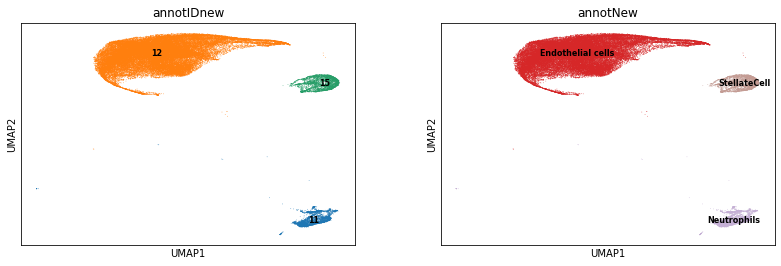

In [42]:
### Create umap
fig=sc.pl.umap(
    adata_slice, 
    color=["annotIDnew","annotNew"],
    alpha=0.9,
    legend_loc="on data",
    legend_fontsize=8,
#     legend_loc="right margin",
    return_fig=True
)

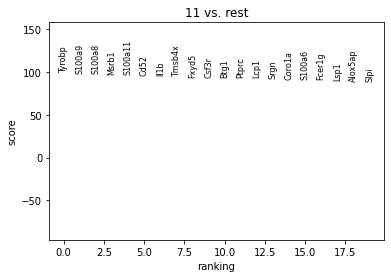

In [55]:
sc.tl.rank_genes_groups(adata_slice, 'annotIDnew', groups=['11'], method='wilcoxon', n_genes=24768)
sc.pl.rank_genes_groups(adata_slice, groups=['11'], n_genes=20)

In [63]:
DEgenesNeutro=sc.get.rank_genes_groups_df(adata_slice, group='11')
DEgenesNeutro

,scores,names,logfoldchanges,pvals,pvals_adj
0,99.443108,Tyrobp,9.886152,0.0,0.0
1,98.364136,S100a9,14.233986,0.0,0.0
2,98.355843,S100a8,14.878198,0.0,0.0
3,97.648430,Msrb1,6.981619,0.0,0.0
4,97.522217,S100a11,6.333127,0.0,0.0
...,...,...,...,...,...
24763,-92.814980,Sptbn1,-6.120924,0.0,0.0
24764,-92.905151,Il6st,-6.761499,0.0,0.0
24765,-93.422043,Ehd3,-7.124068,0.0,0.0
24766,-94.307068,Eng,-7.412772,0.0,0.0


In [64]:
### Write to file
DEgenesNeutro.to_csv(sampleFolder+'allDEgenesNeutro_scanpy.txt',sep='\t')

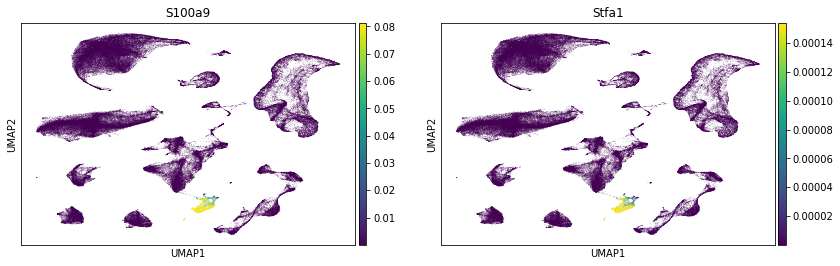

In [75]:
### Plot gene expression - denoised genes
p2=sc.pl.umap(
    post_adata,
    color=['S100a9','Stfa1'],
    show=True,
    layer='norm_genes',
    vmax='p99',
    return_fig=True
)

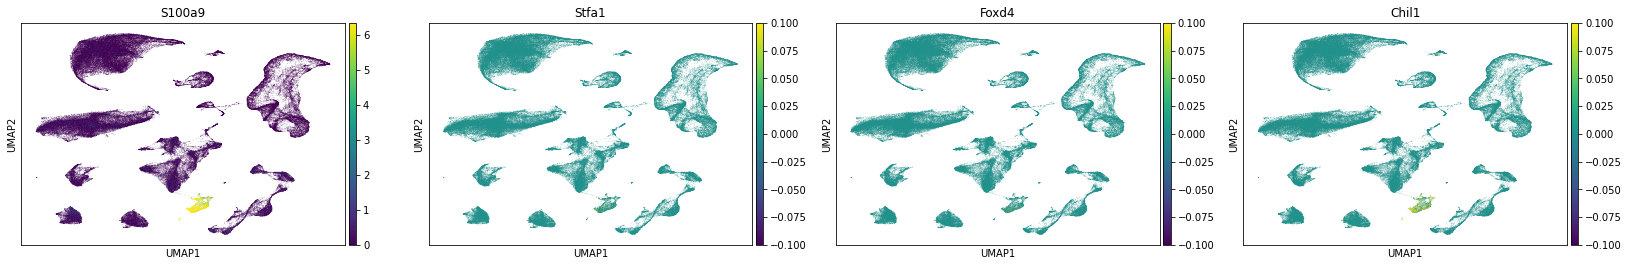

In [78]:
### Plot gene expression - own norm
p2=sc.pl.umap(
    post_adata_full,
    color=['S100a9','Stfa1','Foxd4','Chil1'],
    show=True,
    vmax='p99',
    return_fig=True
)

### HscLsec vs Neutro

In [56]:
adata_slice.obs['annotIDnew'] = adata_slice.obs['annotIDnew'].replace('15', '12')

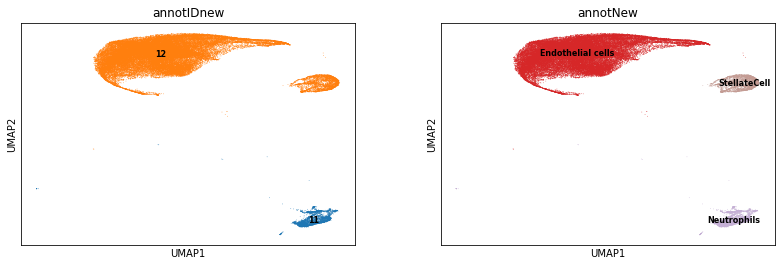

In [57]:
### Create umap
fig=sc.pl.umap(
    adata_slice, 
    color=["annotIDnew","annotNew"],
    alpha=0.9,
    legend_loc="on data",
    legend_fontsize=8,
#     legend_loc="right margin",
    return_fig=True
)

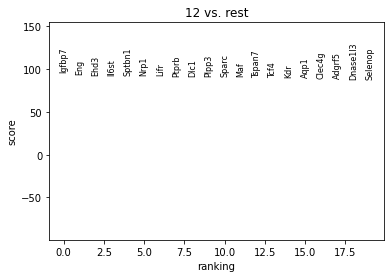

In [58]:
sc.tl.rank_genes_groups(adata_slice, 'annotIDnew', groups=['12'], method='wilcoxon', n_genes=24768)
sc.pl.rank_genes_groups(adata_slice, groups=['12'], n_genes=20)

In [59]:
DEgenesHscLsec=sc.get.rank_genes_groups_df(adata_slice, group='12')
DEgenesHscLsec

,scores,names,logfoldchanges,pvals,pvals_adj
0,96.060692,Igfbp7,7.583676,0.0,0.0
1,94.307068,Eng,7.412772,0.0,0.0
2,93.422043,Ehd3,7.124068,0.0,0.0
3,92.905151,Il6st,6.761499,0.0,0.0
4,92.814980,Sptbn1,6.120924,0.0,0.0
...,...,...,...,...,...
24763,-97.522217,S100a11,-6.333127,0.0,0.0
24764,-97.648430,Msrb1,-6.981619,0.0,0.0
24765,-98.355843,S100a8,-14.878198,0.0,0.0
24766,-98.364136,S100a9,-14.233986,0.0,0.0


In [60]:
### Write to file
DEgenesHscLsec.to_csv(sampleFolder+'allDEgenesHscLsec_scanpy.txt',sep='\t')

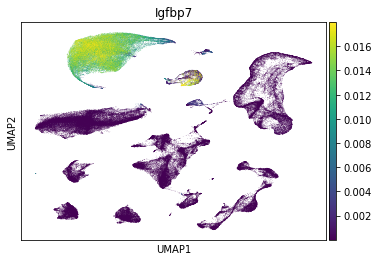

In [72]:
### Plot gene expression - denoised genes
p2=sc.pl.umap(
    post_adata,
    color=['Igfbp7'],
    show=True,
    layer='norm_genes',
    vmax='p99',
    return_fig=True
)

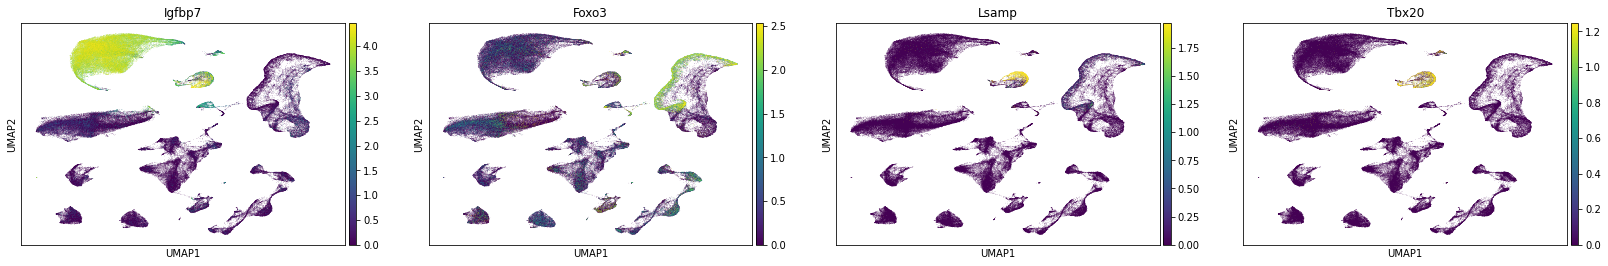

In [80]:
### Plot gene expression - own norm
p2=sc.pl.umap(
    post_adata_full,
    color=['Igfbp7','Foxo3','Lsamp','Tbx20'],
    show=True,
    vmax='p99',
    return_fig=True
)

# Get DE genes via TotalVI

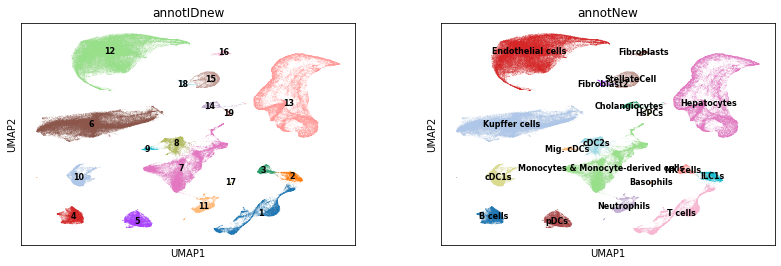

In [26]:
umapAnnotID

In [27]:
### Get annot clusters
clusters = post_adata.obs.annotIDnew.values.astype(int)
print(clusters.shape)

(185894,)


In [28]:
clusters

array([ 1,  1,  2, ..., 11, 11, 11])

In [29]:
np.array(np.unique(clusters, return_counts=True)).T

array([[    1,  9912],
       [    2,  2814],
       [    3,  1974],
       [    4,  6336],
       [    5,  6417],
       [    6, 39311],
       [    7, 20712],
       [    8,  4949],
       [    9,   764],
       [   10,  5436],
       [   11,  3607],
       [   12, 50194],
       [   13, 25908],
       [   14,  1532],
       [   15,  4009],
       [   16,   853],
       [   17,   174],
       [   18,   563],
       [   19,   429]])

In [30]:
### Compare 2 groups (cl0 vs cl1)
# cell_idx1 = clusters == 13
# cell_idx2 = np.array([ix in [10,5,9,2,12,3,4,0,1,16] for ix in clusters])

cell_idx1 = clusters == 15
cell_idx2 = clusters == np.array([ix in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18] for ix in clusters])

In [31]:
### Calculate DE genes
de_res = full_posterior.differential_expression_score(
    cell_idx1,
    cell_idx2,
    n_samples=5000,
    use_permutation=False,
    mode="change"
)

In [44]:
### Plit in genes and proteins
pro_rows = de_res.index.str.contains('adt')
data_rna = de_res.iloc[~pro_rows]
data_pro = de_res.iloc[pro_rows]

In [45]:
### Add score for genes
data_rna['raw_normalized_mean2']=data_rna['raw_normalized_mean2']+0.00001
data_rna["score"] = data_rna["raw_normalized_mean1"]/data_rna["raw_normalized_mean2"]*data_rna["lfc_mean"]
data_rna=data_rna.sort_values(by=['score'],ascending=False)
data_rna

,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,score
Lrrc4c,1.000000,0.000000,18.420681,7.599182e-04,5.670145e-07,11.547440,11.508720,1.774518,0.636274,17.836243,2.332502,0.000000,0.600649,0.000000,11.516764,0.000010,1.329891e+07
Ptprt,0.999799,0.000201,8.510522,4.324816e-04,6.934551e-07,10.461139,10.491440,2.165741,0.132696,17.830132,1.204041,0.000000,0.373909,0.000000,7.192058,0.000010,7.523712e+06
Pcdh9,1.000000,0.000000,18.420681,2.894299e-04,3.098757e-07,10.693722,10.714312,1.761081,0.951139,16.112087,0.914193,0.000000,0.240459,0.000000,4.941206,0.000010,5.283989e+06
Lama1,1.000000,0.000000,18.420681,4.098242e-04,4.659130e-07,11.624603,11.407739,2.448109,1.193817,19.826412,0.962584,0.000000,0.481167,0.000000,3.506535,0.000010,4.076207e+06
Tbx20,1.000000,0.000000,18.420681,3.375342e-04,3.537676e-07,11.427587,11.267830,2.087870,2.534674,18.453068,0.816663,0.000000,0.463707,0.000000,3.146798,0.000010,3.596031e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bcar3,0.752818,0.247182,1.113699,1.218979e-05,2.377898e-05,-0.551344,-0.688004,1.261317,-4.414610,4.560442,0.030432,0.002825,0.030182,0.002825,0.332728,0.012191,-1.504778e+01
Nrg4,0.762882,0.237118,1.168548,1.042793e-05,1.688852e-05,-0.626278,-0.703006,1.365081,-4.831424,4.192377,0.039661,0.004136,0.036169,0.004036,0.660656,0.017741,-2.332249e+01
Gm43388,0.901973,0.098027,2.219337,1.576755e-07,6.988919e-07,-2.147247,-2.327003,2.226630,-9.035994,7.214199,0.000249,0.000101,0.000249,0.000101,0.003229,0.000157,-4.424854e+01
Myl2,0.867955,0.132045,1.882996,1.158011e-07,2.117839e-07,-1.327081,-1.394320,2.249041,-9.261702,6.360970,0.000249,0.000000,0.000249,0.000000,0.005091,0.000010,-6.755622e+02


In [46]:
### Add score for proteins
data_pro['raw_mean2']=data_pro['raw_mean2']+0.00001
data_pro["score"] = data_pro["raw_mean1"]/data_pro["raw_mean2"]*data_pro["lfc_mean"]
data_pro=data_pro.sort_values(by=['score'],ascending=False)
data_pro

,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,score
adt-CD73,0.349839,0.650161,-0.619747,27.784725,1.893747,1.660630,4.112720e-06,2.738975,-6.580407,9.521238,14.464705,2.957839,0.140434,0.502421,NaN,NaN,8.120971
adt-CD49a,0.118559,0.881441,-2.006149,4.254765,0.759434,0.449772,4.291534e-06,1.464096,-3.462322,8.835880,2.567972,0.343331,0.045398,0.125807,NaN,NaN,3.364104
adt-CD29,0.173712,0.826288,-1.559546,11.270646,1.815359,0.531718,3.576279e-07,1.347573,-6.504014,8.945683,6.657521,1.659211,0.140933,0.412228,NaN,NaN,2.133498
adt-CD54,0.322262,0.677738,-0.743394,24.454374,5.058192,0.852863,3.576279e-07,1.768656,-7.619836,9.019582,12.691943,7.196539,0.141432,0.524415,NaN,NaN,1.504124
adt-CD38,0.280797,0.719203,-0.940511,34.011028,5.900744,1.461732,0.000000e+00,2.933665,-9.724319,10.681330,3.170117,4.368351,0.139935,0.521893,NaN,NaN,1.060780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
adt-CD43,0.263486,0.736514,-1.027926,1.136140,6.648531,-1.094554,-3.755093e-06,2.146922,-7.399435,5.348456,0.606635,8.091314,0.128960,0.531174,NaN,NaN,-0.082063
adt-CD55,0.156602,0.843398,-1.683729,2.393845,4.787991,-0.468950,0.000000e+00,1.933814,-9.093600,9.084342,0.683712,3.541878,0.137441,0.512914,NaN,NaN,-0.090524
adt-CD102,0.199678,0.800322,-1.388308,2.407412,3.534463,-0.376738,-1.788139e-07,1.726972,-7.803375,7.564198,0.752557,2.945531,0.133450,0.517655,NaN,NaN,-0.096253
adt-CD8a,0.130837,0.869163,-1.893575,0.992826,2.865920,-0.480221,-1.877546e-05,1.450848,-6.594090,5.920161,0.736343,3.645188,0.122225,0.461562,NaN,NaN,-0.097007


In [47]:
### Write to file
data_rna.to_csv(sampleFolder+'resultsGSEA/allDEgenes.txt',sep='\t')
data_pro.to_csv(sampleFolder+'resultsGSEA/allDEproteins.txt',sep='\t')

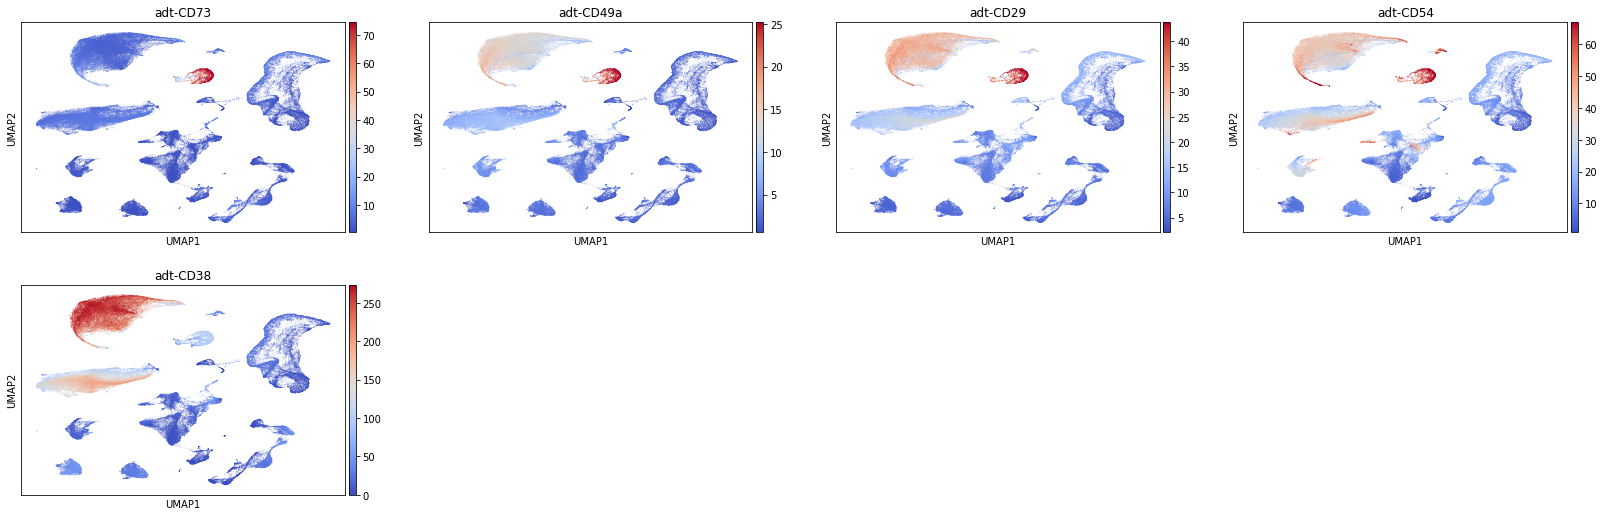

In [49]:
### Plot proteins
p2=sc.pl.umap(
    post_adata,
    color=['adt-CD73','adt-CD49a','adt-CD29','adt-CD54','adt-CD38'],
    show=True,
    vmax='p99',
    color_map="coolwarm",
    return_fig=True
)

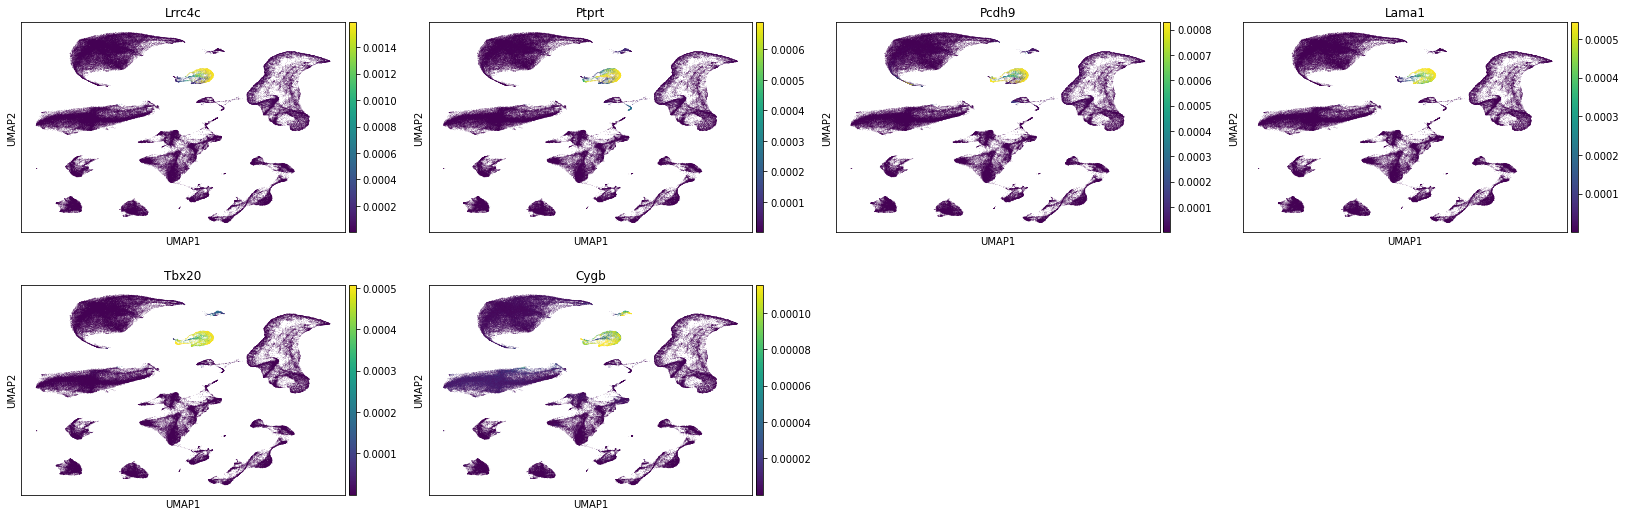

In [51]:
### Plot gene expression - denoised genes
p2=sc.pl.umap(
    post_adata,
    color=['Lrrc4c','Ptprt','Pcdh9','Lama1','Tbx20','Cygb'],
    show=True,
    layer='norm_genes',
    vmax='p99',
    return_fig=True
)

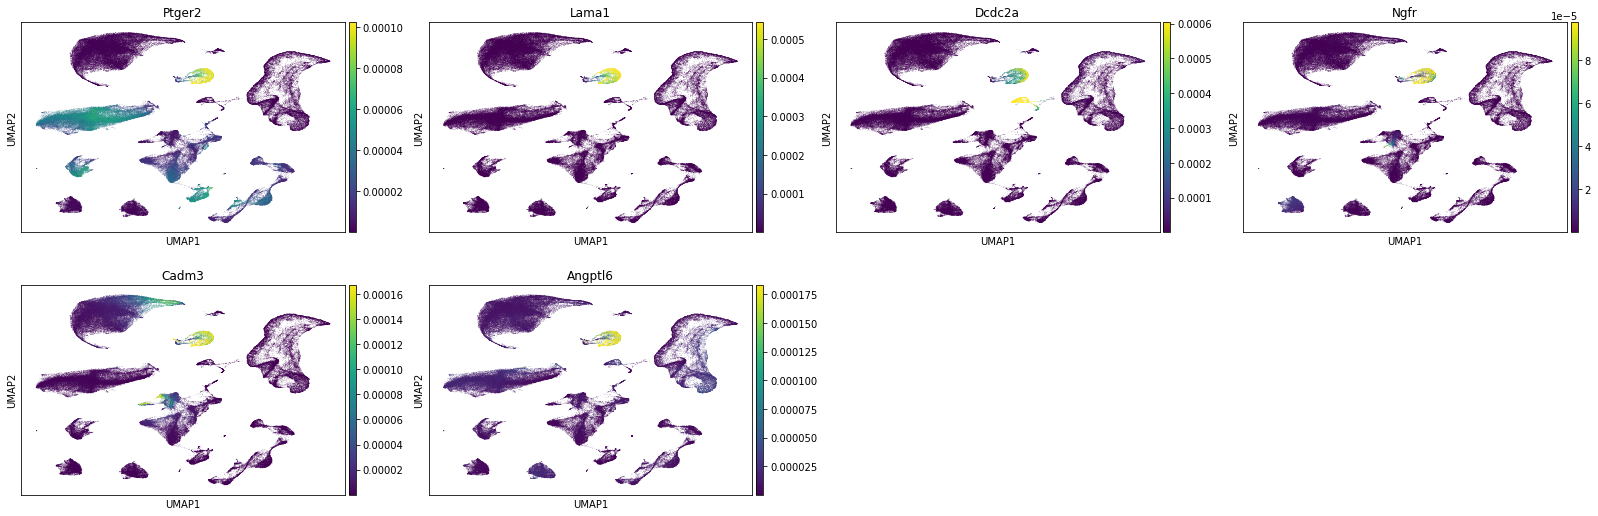

In [51]:
### Plot known markers
p2=sc.pl.umap(
    post_adata,
    color=['Ptger2','Lama1','Dcdc2a','Ngfr','Cadm3','Angptl6'],
    show=True,
    layer='norm_genes',
    vmax='p99',
    return_fig=True
)

# DE genes per annot cluster

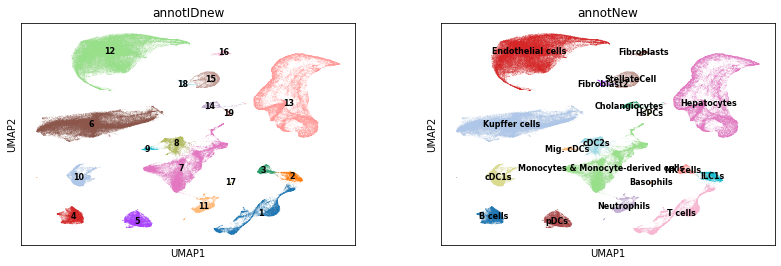

In [61]:
umapAnnotID

In [28]:
### Get annot clusters
clusters = post_adata.obs.annotID.values.astype(int)
print(clusters.shape)

(185894,)


In [29]:
clusters

array([12, 12, 11, ...,  8,  8,  8])

In [30]:
np.array(np.unique(clusters, return_counts=True)).T

array([[    0, 50194],
       [    1,  5425],
       [    2, 25908],
       [    3,  1532],
       [    4,   429],
       [    5,  4949],
       [    6,   764],
       [    7, 20712],
       [    8,  3607],
       [    9,   174],
       [   10,  1974],
       [   11,  2814],
       [   12,  9912],
       [   13,  6417],
       [   14,  6336],
       [   15,  5436],
       [   16, 39311]])

In [31]:
### Calculate markers for each cluster
per_cluster_de, cluster_id = full_posterior.one_vs_all_degenes(
    cell_labels=clusters,
    min_cells=1,
    n_samples=5000,
    use_permutation=False,
    mode="change",
    delta=0.2
)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [04:30<00:00, 15.91s/it]


In [32]:
allGenes_rna = []
allABs_adt = []
for i, cid in enumerate(cluster_id):
    pcd = per_cluster_de[i].sort_values("lfc_median", ascending=False)

    pro_rows = pcd.index.str.contains('adt')
    data_rna = pcd.iloc[~pro_rows]
    data_pro = pcd.iloc[pro_rows]

    allGenes_rna.append(data_rna)
    allABs_adt.append(data_pro)

allGenesTable=pd.concat(allGenes_rna)
allABsTable=pd.concat(allABs_adt)

In [40]:
tmp=allGenesTable[allGenesTable['clusters']==16]
tmp

,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
Slc1a3,0.999799,0.000201,8.510522,0.000108,0.000002,7.450134,7.407922,2.299436,-1.093490,17.970747,0.161024,0.001535,0.130981,0.001378,0.470991,0.004482,16
Cd5l,0.999799,0.000201,8.510522,0.007420,0.000100,7.447838,7.346679,2.192721,-1.563457,17.852608,28.311185,0.165333,0.970721,0.099670,61.125343,0.376823,16
Kcnj10,0.997987,0.002013,6.206168,0.000124,0.000003,7.298822,7.157514,2.546532,-3.902603,18.286610,0.331002,0.005690,0.227951,0.004912,0.735451,0.013678,16
Pcolce2,0.998994,0.001006,6.900318,0.000405,0.000008,7.220444,7.056158,2.483345,-2.416166,16.971264,0.906718,0.012205,0.424665,0.006215,1.861612,0.021302,16
Vsig4,0.997987,0.002013,6.206168,0.003706,0.000058,7.144015,7.046488,2.271362,-1.801317,17.825157,13.671568,0.099514,0.911501,0.061931,26.665122,0.232021,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cdc42ep3,0.984702,0.015298,4.164623,0.000007,0.000155,-3.577031,-4.226686,2.913484,-10.642064,9.221565,0.011447,0.301099,0.010506,0.194395,0.041083,0.754923,16
Cbfa2t3,0.974436,0.025564,3.640689,0.000020,0.000428,-3.264316,-4.262281,3.109219,-9.610971,8.959534,0.028262,0.942292,0.023632,0.382732,0.106638,1.862176,16
Ccdc88c,0.977254,0.022746,3.760376,0.000012,0.000257,-3.518331,-4.279103,2.939939,-9.965003,7.070362,0.012694,0.356460,0.011956,0.236931,0.061076,1.016336,16
S100a10,0.995773,0.004227,5.462012,0.000067,0.001413,-4.365523,-4.415025,1.448455,-9.272829,3.106238,0.100506,2.379614,0.087456,0.653984,0.393075,5.578835,16


In [41]:
tmp2=allABsTable[allABsTable['clusters']==16]
tmp2

,proba_de,proba_not_de,bayes_factor,scale1,scale2,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,clusters
adt-CD64,0.227858,0.772142,-1.220444,1.313868,0.565819,0.591088,0.000020,1.189516,-2.533013,4.964679,1.500038,0.489511,0.523340,0.252396,NaN,NaN,16
adt-F4-80,0.253019,0.746981,-1.082573,2.757425,0.934868,0.697215,0.000013,1.528370,-4.823928,6.014197,4.415736,0.846353,0.654499,0.340326,NaN,NaN,16
adt-Folate,0.362118,0.637882,-0.566185,27.635118,1.995791,2.195254,0.000013,3.187093,-4.503981,9.459188,50.544502,1.525088,0.680725,0.345156,NaN,NaN,16
adt-CD44-mh,0.225845,0.774155,-1.231921,12.141483,5.335746,0.277012,0.000009,0.870437,-7.625882,9.285469,17.448805,6.670617,0.540688,0.252028,NaN,NaN,16
adt-CD86,0.246578,0.753422,-1.116947,6.094465,1.136754,1.137470,0.000009,2.207665,-6.020047,9.064131,10.625169,2.612486,0.681870,0.408861,NaN,NaN,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
adt-CD45,0.013084,0.986916,-4.323215,0.509831,0.510162,-0.000589,0.000000,0.163060,-1.754962,1.767746,0.037267,0.018290,0.037216,0.018256,NaN,NaN,16
adt-CD24,0.075886,0.924114,-2.499608,0.891370,2.079714,-0.270917,0.000000,1.236051,-7.548548,6.486479,1.767648,3.192744,0.531683,0.378257,NaN,NaN,16
adt-CD27-A0191,0.031200,0.968800,-3.435650,0.886630,0.855385,0.000240,0.000000,0.211686,-7.195323,6.444450,1.941441,1.431244,0.498563,0.325979,NaN,NaN,16
adt-CD357,0.076087,0.923913,-2.496741,1.468270,1.390855,0.002196,0.000000,0.438925,-6.784960,5.135430,2.290936,1.699112,0.543385,0.356460,NaN,NaN,16


### Get DE genes

In [ ]:
### Get DE genes: function
def getDEgenes_perCluster(per_cluster_de, cluster_id):
    filtered_rna = []
    for i, cid in enumerate(cluster_id):
        pcd = per_cluster_de[i].sort_values("lfc_median", ascending=False)

        pcd = pcd[pcd.lfc_median > 1.5]

        pro_rows = pcd.index.str.contains('adt')
        data_rna = pcd.iloc[~pro_rows]
        data_rna = data_rna[data_rna["bayes_factor"] > 1]
        data_rna = data_rna[data_rna["non_zeros_proportion1"] > 0.20]
        
        data_rna["score"] = data_rna["raw_normalized_mean1"]/data_rna["raw_normalized_mean2"]*data_rna["lfc_mean"]

        filtered_rna.append(data_rna)
    
    toReturn=pd.concat(filtered_rna)
    toReturn=toReturn.sort_values(['clusters', 'lfc_median'], ascending=[True, False])
    return(toReturn)

In [ ]:
### Get DE genes
clustermarkers = getDEgenes_perCluster(per_cluster_de, cluster_id)
columns_oi=['proba_de','bayes_factor','lfc_mean','lfc_median','raw_normalized_mean1','raw_normalized_mean2','clusters','score']
clustermarkers[columns_oi]

In [ ]:
clustermarkers.shape

In [ ]:
np.array(np.unique(clustermarkers['clusters'], return_counts=True)).T

In [ ]:
### Get markers of certain cluster
tmp=clustermarkers[clustermarkers['clusters']==16]
tmp[columns_oi]

### Get DE proteins

In [ ]:
### Get DE proteins: function
def getDEproteins_perCluster_lessStrict(per_cluster_de, cluster_id):
    filtered_pro = []
    for i, cid in enumerate(cluster_id):
        pcd = per_cluster_de[i].sort_values("lfc_median", ascending=False)

        pcd = pcd[pcd.proba_de > 0.05]

        pro_rows = pcd.index.str.contains('adt')
        data_pro = pcd.iloc[pro_rows]
        
        data_pro["score"] = data_pro["raw_mean1"]/data_pro["raw_mean2"]*data_pro["lfc_mean"]
        data_pro = data_pro[data_pro.score >= 0.5]

        filtered_pro.append(data_pro)
    
    toReturn=pd.concat(filtered_pro)
    toReturn=toReturn.sort_values(['clusters', 'lfc_median'], ascending=[True, False])
    return(toReturn)

In [ ]:
### Get DE proteins
clusterproteins = getDEproteins_perCluster_lessStrict(per_cluster_de, cluster_id)
columns_oi=['proba_de','bayes_factor','lfc_mean','lfc_median','raw_mean1','raw_mean2','clusters','score']
clusterproteins[columns_oi]

In [ ]:
clusterproteins.shape

In [ ]:
np.array(np.unique(clusterproteins['clusters'], return_counts=True)).T

In [ ]:
### Get proteins of certain cluster
tmp=clusterproteins[clusterproteins['clusters']==16]
tmp[columns_oi]